### Advanced Machine Learning

# Home Exercise #2

Assignment Due: 18/04/21 23:59

Jonathan Schler

In [32]:
!pip install seaborn
!pip install xlrd
!pip install imblearn
!pip install xgboost


In [48]:
!pip install pydotplus


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report


%matplotlib inline

The goal of this homework is to provide a realistic setting for a machine learning task. Therefore instructions will not specify the exact steps to carry out. Instead, it is part of theassignment to identify promising features, models and preprocessing methods and apply themas appropriate.

The overall goal is to predict whether a specific credit card transaction is fraudulent or not. Please use the data from this dataset provided on Kaggle here:https://www.kaggle.com/kartik2112/fraud-detection. The Kaggle page also contains a description of the dataset. You will use the train set for training the model and test set for validation.

You are free to manipulate the train dataset as you think is appropriate. You do not have to use the wholedataset, you can subsample if you want. While the modelling process is likely iterative, please lay out the  following tasks in the given order to facilitate grading.

## Task 1 Identify Features
Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y). What features are relevant for the prediction task? What features should be excluded because they leak the target information? Show visualizations or statistics to support your selection

In [4]:
df = pd.read_csv("fraudTrain.csv",nrows=500000)
test = pd.read_csv('fraudTest.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
df=df.drop("trans_date_trans_time", axis=1)
print("trans_date_trans_time and unix time are the same ")

trans_date_trans_time and unix time are the same 


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  500000 non-null  int64  
 1   cc_num      500000 non-null  int64  
 2   merchant    500000 non-null  object 
 3   category    500000 non-null  object 
 4   amt         500000 non-null  float64
 5   first       500000 non-null  object 
 6   last        500000 non-null  object 
 7   gender      500000 non-null  object 
 8   street      500000 non-null  object 
 9   city        500000 non-null  object 
 10  state       500000 non-null  object 
 11  zip         500000 non-null  int64  
 12  lat         500000 non-null  float64
 13  long        500000 non-null  float64
 14  city_pop    500000 non-null  int64  
 15  job         500000 non-null  object 
 16  dob         500000 non-null  object 
 17  trans_num   500000 non-null  object 
 18  unix_time   500000 non-null  int64  
 19  me

as we can see, we have corelation with some features


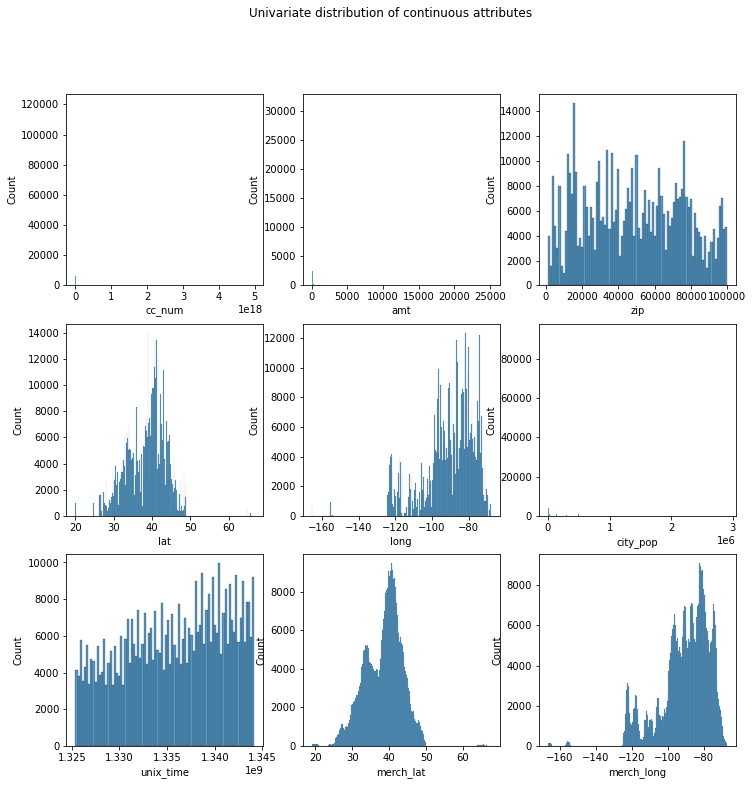

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Univariate distribution of continuous attributes')
continues_cat = df.select_dtypes(exclude=['object']).columns.tolist()
remove_cat = ["Unnamed: 0","is_fraud"]
for i in remove_cat:
    continues_cat.remove(i)
for i, cat in enumerate(continues_cat):
     sns.histplot(ax=axes[i//3,i%3], data=df, x=cat)
print("as we can see, we have corelation with some features")

In [8]:
df=df.drop("Unnamed: 0", axis=1)

In [9]:
correlation_df = df.corr()
correlation_df.style.background_gradient(cmap='coolwarm', axis=None)


,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
cc_num,1.000000,0.000558,0.041379,-0.057926,-0.047805,-0.008832,0.000024,-0.057724,-0.047761,-0.002728
amt,0.000558,1.000000,-0.000314,0.001479,0.001591,0.004413,-0.004098,0.001291,0.001601,0.221015
zip,0.041379,-0.000314,1.000000,-0.113809,-0.909932,0.078367,-0.000893,-0.112988,-0.909110,-0.003677
lat,-0.057926,0.001479,-0.113809,1.000000,-0.017594,-0.156305,-0.000528,0.993591,-0.017573,0.006939
long,-0.047805,0.001591,-0.909932,-0.017594,1.000000,-0.052041,0.000623,-0.017640,0.999119,0.002062
city_pop,-0.008832,0.004413,0.078367,-0.156305,-0.052041,1.000000,-0.002649,-0.155309,-0.052069,0.000571
unix_time,0.000024,-0.004098,-0.000893,-0.000528,0.000623,-0.002649,1.000000,-0.000743,0.000647,-0.025738
merch_lat,-0.057724,0.001291,-0.112988,0.993591,-0.017640,-0.155309,-0.000743,1.000000,-0.017629,0.006869
merch_long,-0.047761,0.001601,-0.909110,-0.017573,0.999119,-0.052069,0.000647,-0.017629,1.000000,0.002046
is_fraud,-0.002728,0.221015,-0.003677,0.006939,0.002062,0.000571,-0.025738,0.006869,0.002046,1.000000


we can see we really have correalation between merch_long and long and merch_lat and lat ,althow we can see the amt is meaningfull to ouer target

In [10]:
df = pd.concat([
        df.select_dtypes([], ['object']),
        df.select_dtypes(['object']).apply(pd.Categorical, ordered=True)
        ], axis=1).reindex(df.columns, axis=1)

In [11]:
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [12]:
df=df.drop(['lat','long'], axis=1)

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import SMOTE

In [14]:
y = df['is_fraud']
x = df.drop(columns=['is_fraud'])
columns = list(df.columns)
columns.remove('is_fraud')
smote_pipe = make_imb_pipeline(SMOTE(), LogisticRegression(solver='lbfgs'))
scores = cross_val_score(smote_pipe, x, y,cv=5)
result = np.mean(scores)

results = {}

for col in columns:
    temp = x.drop(columns=[col])
    results[col] = np.mean(cross_val_score(smote_pipe, temp, y, cv = 5))
    print("Finished cross validating on {} feature.".format(col))


Finished cross validating on cc_num feature.
Finished cross validating on merchant feature.
Finished cross validating on category feature.
Finished cross validating on amt feature.
Finished cross validating on first feature.
Finished cross validating on last feature.
Finished cross validating on gender feature.
Finished cross validating on street feature.
Finished cross validating on city feature.
Finished cross validating on state feature.
Finished cross validating on zip feature.
Finished cross validating on city_pop feature.
Finished cross validating on job feature.
Finished cross validating on dob feature.
Finished cross validating on trans_num feature.
Finished cross validating on unix_time feature.
Finished cross validating on merch_lat feature.
Finished cross validating on merch_long feature.


In [15]:
diffs = [result - res for res in results.values()]
print(diffs)
df = df.drop("cc_num", axis=1)

[0.406196, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [16]:
#df = df.drop("cc_num", axis=1)

It is clearly apparent there is data leakage in cc_number; it is the only feature with decrease in score upon removing it and the decrease is huge; a feature which is not even representive/descriptive and hence can only cause data leakage.

# Task2 Preprocessing and Baseline Model
Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset

In [17]:
features = ['merchant','category','street','dob','amt','city_pop', 'gender','state','city']
categorials = ['merchant','category','street','dob','gender','state','city']
numeric = ['amt','city_pop']

In [18]:
y = df['is_fraud']
x = df[features]
smt = SMOTE(random_state=0)
x,y = smt.fit_resample(x,y)


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier


cat_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, categorials),('scalar',StandardScaler(),numeric)])


clf = Pipeline(steps=[('preprocessor',preprocessor),
                      ('classifier', SGDClassifier())])
score = cross_val_score(clf, x, y, cv = 5).mean()

print("Score for cross validating with randomforest model (With scaling):{}".format(score))

Score for cross validating with randomforest model (With scaling):0.9271851404149449


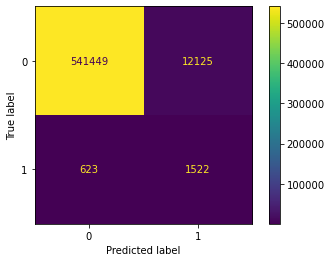

In [21]:
test_labels = test['is_fraud']
test_features = test[features]
clf.fit(x,y)
plot_confusion_matrix(clf,test_features,test_labels)
plt.show()

In [22]:
predictions = clf.predict(test_features)

print(classification_report(test_labels,predictions,target_names=['not_fraud','fraud']))

              precision    recall  f1-score   support

   not_fraud       1.00      0.98      0.99    553574
       fraud       0.11      0.71      0.19      2145

    accuracy                           0.98    555719
   macro avg       0.56      0.84      0.59    555719
weighted avg       1.00      0.98      0.99    555719



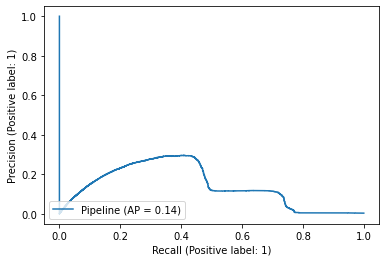

In [23]:
from sklearn.metrics import plot_precision_recall_curve, precision_recall_fscore_support

pr_rf = plot_precision_recall_curve(clf, test_features, test_labels,ax=plt.gca())


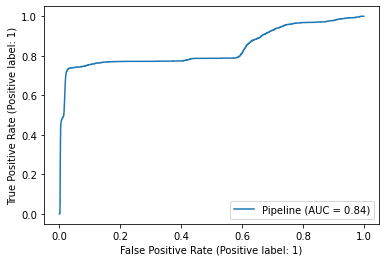

In [24]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(clf, test_features, test_labels,ax=plt.gca())

## Task 3 Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

In [7]:
df1 = pd.read_csv("fraudTrain.csv",nrows=500000)
test1 = pd.read_csv('fraudTest.csv')
drop=['lat','long','cc_num','Unnamed: 0','trans_date_trans_time']
df1=df1.drop(columns=drop)
test1 = test1.drop(columns=drop)

In [8]:
from datetime import datetime

df1['full name'] = df1['first'] + ' ' + df1['last']
df1['date time'] = pd.to_datetime(df1['unix_time'], unit='s')
df1['Day'] = [datetime.date() for datetime in df1['date time']]
df1['Time'] = [datetime.time() for datetime in df1['date time']]

test1['full name'] = test1['first'] + ' ' + test1['last']
test1['date time'] = pd.to_datetime(test1['unix_time'], unit='s')
test1['Day'] = [datetime.date() for datetime in test1['date time']]
test1['Time'] = [datetime.time() for datetime in test1['date time']]

curr = datetime(2020,12,31)

def extract_age(x):
    arr = [int(e) for e in x.split('-')]
    person = datetime(arr[0],arr[1],arr[2])
    diff = curr - person
    age = diff.days//365
    return age 

df1['Age'] = df1['dob'].apply(lambda x: extract_age(x))
test1['Age'] = test1['dob'].apply(lambda x: extract_age(x))

In [9]:
df1[['numberstreer','nametreet']] = df1['street'].str.split(n=1, expand=True)
test1[['numberstreer','nametreet']] = test1['street'].str.split(n=1, expand=True)

df1 = df1.drop(columns=['dob','first','last','date time','street','unix_time'])
test1 = test1.drop(columns=['dob','first','last','date time','street','unix_time'])



In [10]:
from sklearn.preprocessing import LabelEncoder


categorials: list = df1.columns[df1.dtypes == object].to_list()
categorials.remove('Time')

df1[categorials] = df1[categorials].apply(lambda x: x.astype('category').cat.codes)
test1[categorials] = test1[categorials].apply(lambda x: x.astype('category').cat.codes)

df1['Time'] = df1['Time'].apply(lambda x: x.minute + x.second/60)
test1['Time'] = test1['Time'].apply(lambda x: x.minute + x.second/60)


In [11]:
def generate_num_of_frauds(merchs, is_fraud):
    frauds_involved = []
    frauds = {}
    for i,merch in enumerate(merchs):
        if merch in frauds.keys():
            if is_fraud[i] == 1:
                frauds[merch] += 1
        else:
            frauds[merch] = int(np.sum([1 if m == merch else 0 for m in is_fraud[:i]]))
        frauds_involved.append(frauds[merch])
    return np.array(frauds_involved)


df1['frauds_involved'] = generate_num_of_frauds(df1['merchant'],df1['is_fraud'])
test1['frauds_involved'] = generate_num_of_frauds(test1['merchant'],test1['is_fraud'])
df1.head()

,merchant,category,amt,gender,city,state,zip,city_pop,job,trans_num,merch_lat,merch_long,is_fraud,full name,Day,Time,Age,numberstreer,nametreet,frauds_involved
0,514,8,4.97,0,509,27,28654,3495,361,21651,36.011293,-82.048315,0,397,0,0.300000,32,516,675,0
1,241,4,107.23,0,587,47,99160,149,417,61199,49.159047,-118.186462,0,828,0,0.733333,42,401,718,0
2,390,0,220.11,1,455,13,83252,4154,299,315571,43.150704,-112.154481,0,284,0,0.850000,58,548,907,0
3,360,2,45.00,1,83,26,59632,1939,320,209881,47.034331,-112.561071,0,415,0,1.266667,54,843,197,0
4,297,9,41.96,1,211,45,24433,99,113,320344,38.674999,-78.632459,0,891,0,3.100000,34,387,91,0


## Task 4 Any model
Use any classification model we discussed (trees, forests, boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate

In [12]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

y = df1['is_fraud']
X = df1.drop(columns=['is_fraud'])

y_test = test1['is_fraud']
x_test = test1.drop(columns=['is_fraud'])

# Balance the training data.
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

x_train_sub, x_val, y_train_sub,y_val = train_test_split(X,y,random_state=0)

In [13]:
#without grid search
xgb = XGBClassifier()
xgb.fit(x_train_sub, y_train_sub)
scores_non = xgb.predict_proba(x_test)[:,1]

cal_xgb = CalibratedClassifierCV(xgb, cv='prefit', method='sigmoid')
cal_xgb.fit(x_val,y_val)
scores_sigm = cal_xgb.predict_proba(x_test)[:,1]

cal_xgb_iso = CalibratedClassifierCV(xgb,cv='prefit',method='isotonic')
cal_xgb_iso.fit(x_val, y_val)
scores_iso = cal_xgb_iso.predict_proba(x_test)[:,1]

C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:24:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  

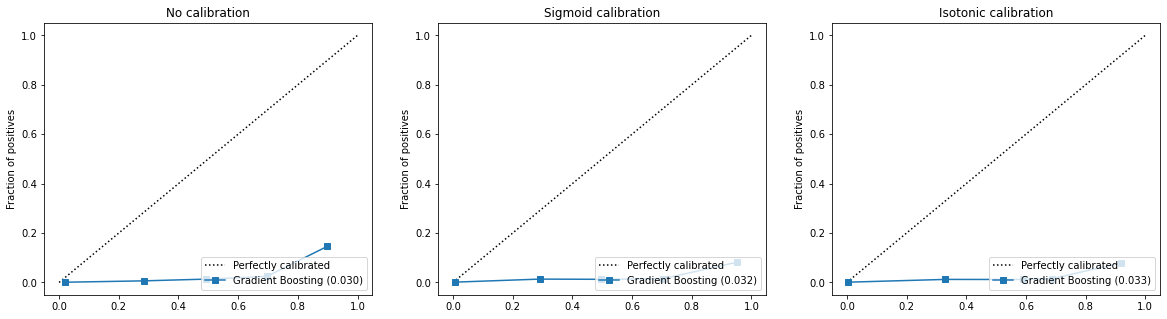

In [14]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))

scores = [scores_non, scores_sigm, scores_iso]
names = ['No calibration','Sigmoid calibration', 'Isotonic calibration']
fractions = [] 
means = []
clf_scores = []

for score in scores:
    frac_of_pos, mean_pred = calibration_curve(y_test, score)
    # Measures the mean squared difference between predicted probability and actual outcome.
    clf_score = brier_score_loss(y_test, score, pos_label=y.max())
    fractions.append(frac_of_pos)
    means.append(mean_pred)
    clf_scores.append(clf_score)


for i,axis in enumerate([ax1,ax2,ax3]):
    axis.plot([0,1],[0,1],"k:",label="Perfectly calibrated")
    axis.plot(means[i], fractions[i], "s-",
                 label="%s (%1.3f)" % ('Gradient Boosting', clf_scores[i]))
    
    axis.set_ylabel("Fraction of positives")
    axis.set_ylim([-0.05, 1.05])
    axis.legend(loc="lower right")
    axis.set_title('{}'.format(names[i]))

plt.show()


In [15]:
print("Score of XGBoost without calibration: {}".format(xgb.score(x_test,y_test)))
print("Score of XGBoos with calibration: {}".format(cal_xgb.score(x_test,y_test)))
print("Score of XGBoost with isotonic calibration: {}".format(cal_xgb_iso.score(x_test,y_test)))

C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Score of XGBoost without calibration: 0.9594525290659488


C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Score of XGBoos with calibration: 0.9607697415420383


C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Score of XGBoost with isotonic calibration: 0.9576008738229213


C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


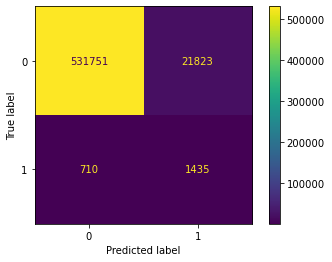

In [16]:
plot_confusion_matrix(xgb,x_test,y_test)
plt.show()

In [17]:
predictions = xgb.predict(x_test)

print(classification_report(y_test,predictions,target_names=['not_fraud','fraud']))

C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


              precision    recall  f1-score   support

   not_fraud       1.00      0.96      0.98    553574
       fraud       0.06      0.67      0.11      2145

    accuracy                           0.96    555719
   macro avg       0.53      0.81      0.55    555719
weighted avg       1.00      0.96      0.98    555719



C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


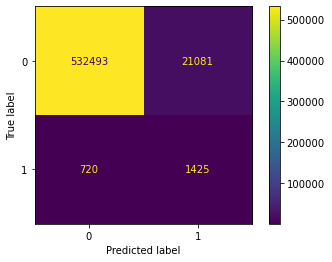

In [18]:
plot_confusion_matrix(cal_xgb,x_test,y_test)
plt.show()

In [19]:
predictions = cal_xgb.predict(x_test)

print(classification_report(y_test,predictions,target_names=['not_fraud','fraud']))

C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


              precision    recall  f1-score   support

   not_fraud       1.00      0.96      0.98    553574
       fraud       0.06      0.66      0.12      2145

    accuracy                           0.96    555719
   macro avg       0.53      0.81      0.55    555719
weighted avg       1.00      0.96      0.98    555719



C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


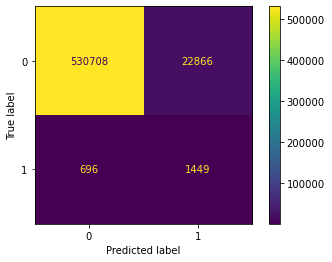

In [20]:
plot_confusion_matrix(cal_xgb_iso,x_test,y_test)
plt.show()

In [21]:
predictions = cal_xgb_iso.predict(x_test)

print(classification_report(y_test,predictions,target_names=['not_fraud','fraud']))

C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


              precision    recall  f1-score   support

   not_fraud       1.00      0.96      0.98    553574
       fraud       0.06      0.68      0.11      2145

    accuracy                           0.96    555719
   macro avg       0.53      0.82      0.54    555719
weighted avg       1.00      0.96      0.97    555719



C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


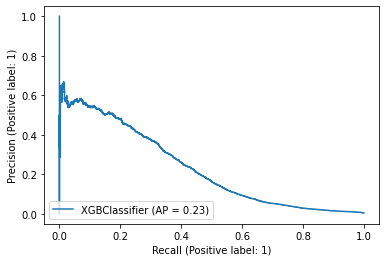

In [22]:
from sklearn.metrics import plot_precision_recall_curve, precision_recall_fscore_support

pr_rf = plot_precision_recall_curve(xgb, x_test, y_test,ax=plt.gca())

C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


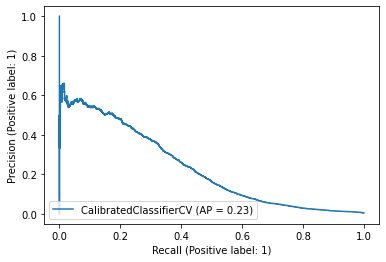

In [23]:
pr_rf = plot_precision_recall_curve(cal_xgb, x_test, y_test,ax=plt.gca())

C:\Users\Yakov\miniconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


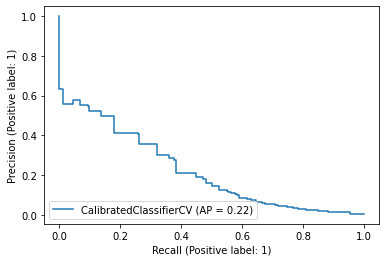

In [24]:
pr_rf = plot_precision_recall_curve(cal_xgb_iso, x_test, y_test,ax=plt.gca())

## Task 5 Feature Selections
Identify features that are important for your best model. Which features are most influential,and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

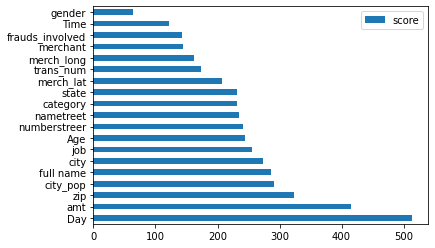

In [25]:
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

we can see that the feater time and gender are not so  importent

In [26]:
from sklearn.feature_selection import mutual_info_classif

y = df1['is_fraud']
X = df1.drop(columns=['is_fraud'])

mutual_info = mutual_info_classif(X,y)

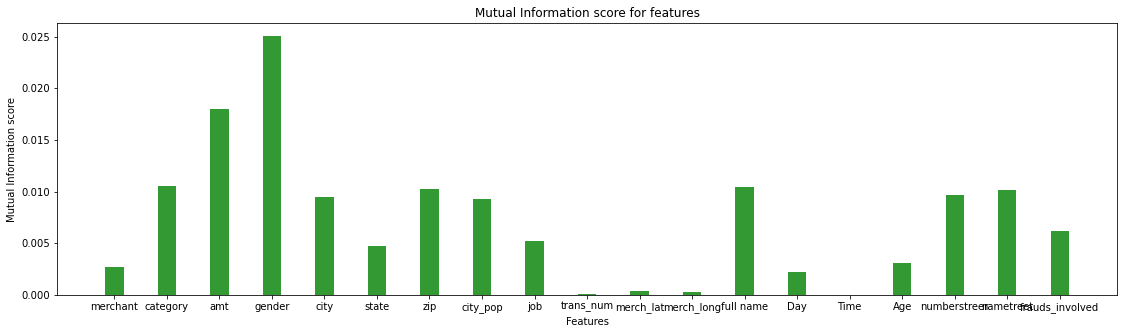

In [27]:
cols = X.columns
index = np.arange(mutual_info.shape[0])


fig = plt.figure(figsize=(19,5))
plt.bar(index, mutual_info,0.35,alpha=0.8,color='g',label='Scores')

plt.xlabel('Features')
plt.ylabel('Mutual Information score')
plt.title("Mutual Information score for features")
plt.xticks(index, tuple(cols))

plt.show()

In [28]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=20,random_state=0)

y = df1['is_fraud']
X = df1.drop(columns=['is_fraud'])

forest.fit(X,y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


print("Feature ranking:")
for f in range(X.shape[1]):
    print("{}. feature {} ({})".format(f + 1, X.columns[f], importances[indices[f]]))

Feature ranking:
1. feature merchant (0.3326083642023283)
2. feature category (0.08392257190289147)
3. feature amt (0.06580169184198081)
4. feature gender (0.055843737969984486)
5. feature city (0.052201500752520294)
6. feature state (0.05053379984893854)
7. feature zip (0.04380399683041616)
8. feature city_pop (0.0435197233807579)
9. feature job (0.04276166561406163)
10. feature trans_num (0.02865753853463081)
11. feature merch_lat (0.026629018661250347)
12. feature merch_long (0.02606276547030172)
13. feature full name (0.024739630856723253)
14. feature Day (0.024435034427549258)
15. feature Time (0.02316712896276328)
16. feature Age (0.02305820345839697)
17. feature numberstreer (0.022062122862831476)
18. feature nametreet (0.019406831147150215)
19. feature frauds_involved (0.010784673274523085)


In [35]:
samples = df1.sample(n=60000)

y = samples['is_fraud']
X = samples.drop(columns=['is_fraud'])

smote_pipe = make_imb_pipeline(SMOTE(), LogisticRegression(solver='lbfgs'))

scores = cross_val_score(smote_pipe, X, y,cv=5)
result = np.mean(scores)

results = {}

for col in X.columns:
    temp = X.drop(columns=[col])
    results[col] = np.mean(cross_val_score(smote_pipe, temp, y, cv = 5))
    print("Finished cross validating on {} feature.".format(col))

C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on merchant feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on category feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on amt feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on gender feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on city feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on state feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on zip feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on city_pop feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on job feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on trans_num feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on merch_lat feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on merch_long feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on full name feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on Day feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on Time feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on Age feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on numberstreer feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on nametreet feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Finished cross validating on frauds_involved feature.


C:\Users\Yakov\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


([<matplotlib.axis.XTick at 0x1e37e797488>,
 [Text(0, 0, 'merchant'),
  Text(0, 0, 'category'),
  Text(0, 0, 'amt'),
  Text(0, 0, 'gender'),
  Text(0, 0, 'city'),
  Text(0, 0, 'state'),
  Text(0, 0, 'zip'),
  Text(0, 0, 'city_pop'),
  Text(0, 0, 'job'),
  Text(0, 0, 'trans_num'),
  Text(0, 0, 'merch_lat'),
  Text(0, 0, 'merch_long'),
  Text(0, 0, 'full name'),
  Text(0, 0, 'Day'),
  Text(0, 0, 'Time'),
  Text(0, 0, 'Age'),
  Text(0, 0, 'numberstreer'),
  Text(0, 0, 'nametreet'),
  Text(0, 0, 'frauds_involved')])

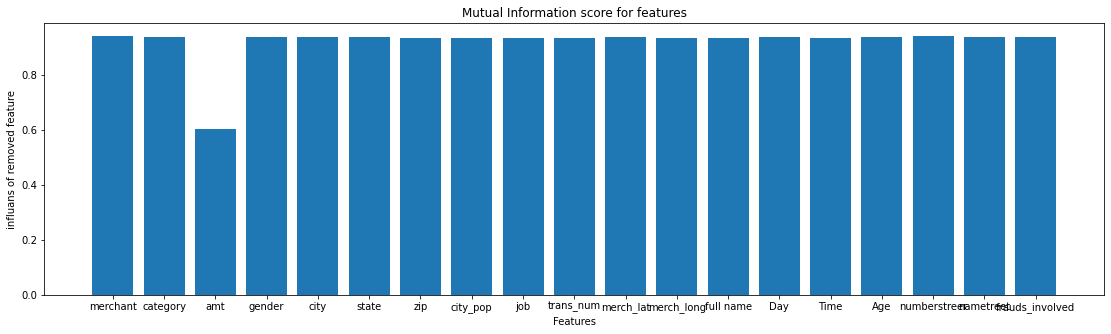

In [36]:
fig = plt.figure(figsize=(19,5))
plt.bar(np.arange(len(X.columns)),results.values())

plt.xlabel('Features')
plt.ylabel('influans of removed feature')
plt.title("Mutual Information score for features")
plt.xticks(np.arange(len(X.columns)), tuple(X.columns))

we can asume from the ifromatiom that wee can remove for unnessery feature- merch lat,merch long,Time,trams num tran features

## Task 6 An explainable model
Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model withfew enough coefficients that you can reasonable look at all of them, or a tree with a smallnumber of leafs etc.

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz


samples = df1.sample(n=60000)
y = samples['is_fraud']
X = samples.drop(columns=['is_fraud'])

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

clf = GradientBoostingClassifier(max_depth=3, random_state=0)
clf.fit(X,y)


GradientBoostingClassifier(random_state=0)

In [55]:
from sklearn.tree import DecisionTreeClassifier

# We sample only 60,000 to be able to perform GridSearchCV.
samples = df1.sample(n=60000)
y = samples['is_fraud']
X = samples.drop(columns=['is_fraud'])

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

depths = [10,15,20]
params = {'max_leaf_nodes':[10,15],'criterion':('gini','entropy')}
clf = GridSearchCV(DecisionTreeClassifier(), params)
clf.fit(X,y)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_leaf_nodes': [10, 15]})

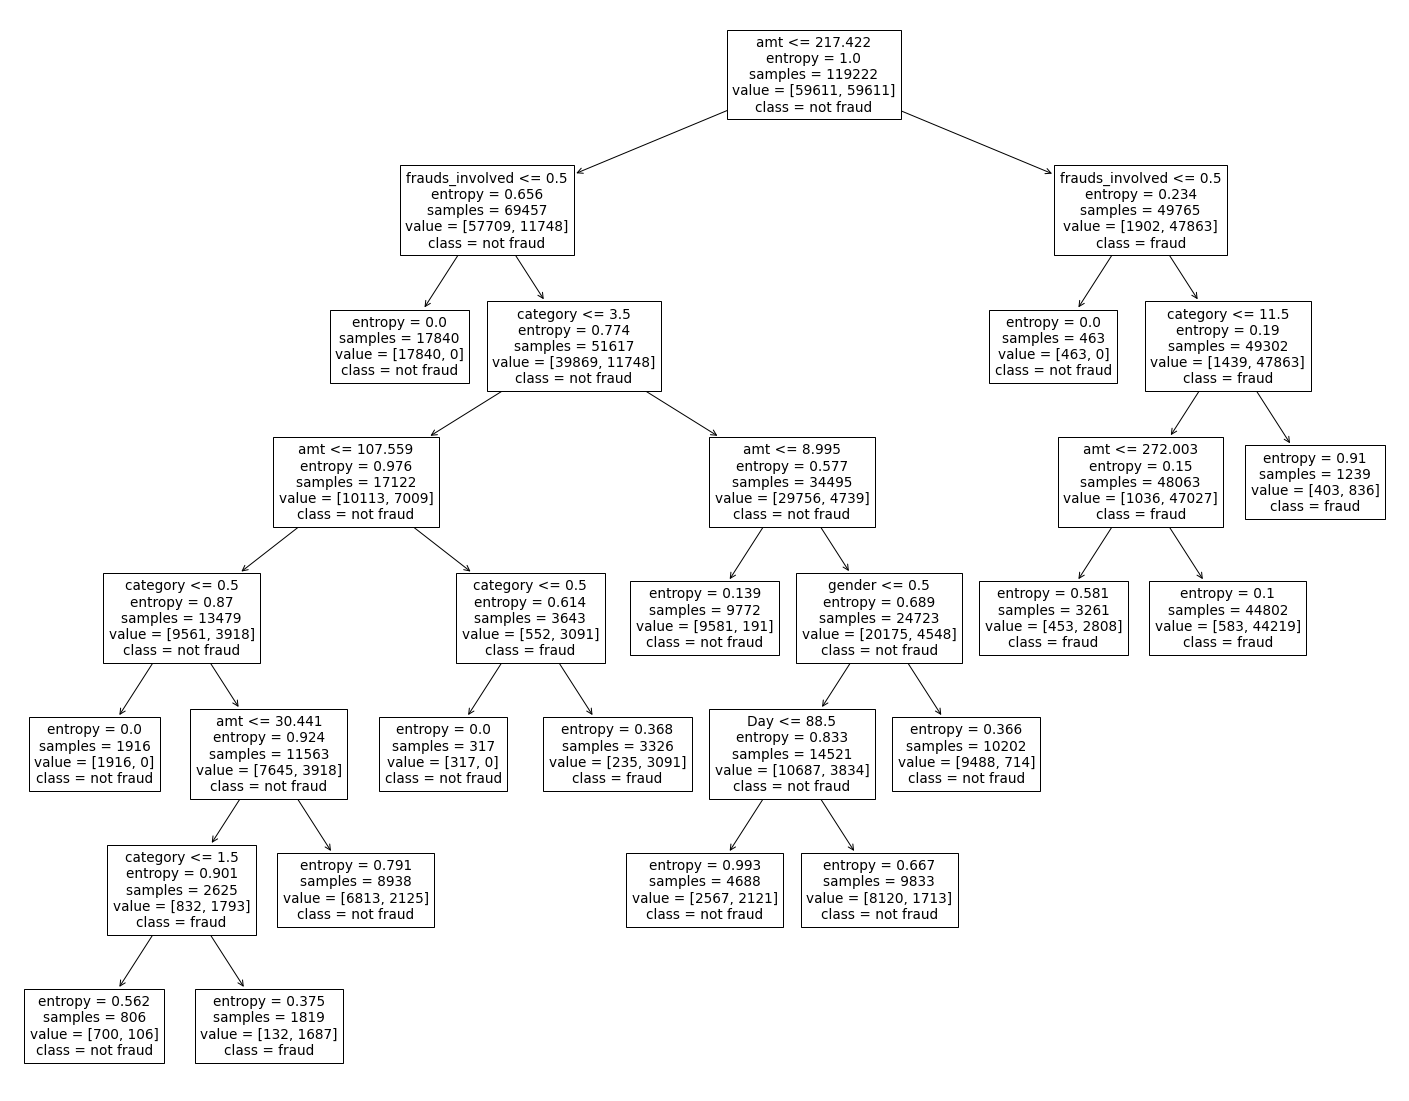

In [56]:
from sklearn import tree

model = clf.best_estimator_
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=list(X.columns),  
                   class_names=['not fraud','fraud'])

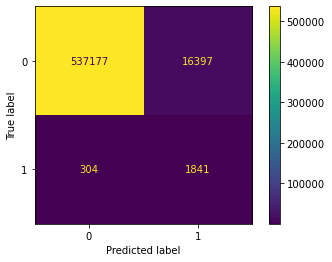

In [57]:
y_test = test1['is_fraud']
x_test = test1.drop(columns=['is_fraud'])

plot_confusion_matrix(model,x_test,y_test)
plt.show()

In [61]:
predictions = model.predict(x_test)

print(classification_report(y_test,predictions,target_names=['not_fraud','fraud']))

              precision    recall  f1-score   support

   not_fraud       1.00      0.97      0.98    553574
       fraud       0.10      0.86      0.18      2145

    accuracy                           0.97    555719
   macro avg       0.55      0.91      0.58    555719
weighted avg       1.00      0.97      0.98    555719



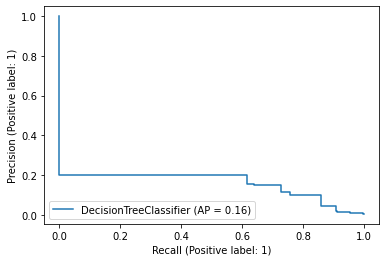

In [64]:
pr_rf = plot_precision_recall_curve(model, x_test, y_test,ax=plt.gca())

We managed to build an explainable Decision Tree model with small number of nodes (samll enough to plot) with 95% accuracy (Keeping in mind that the explaianble model was trained only on a small sample of the whole dataset) in compare to the 96% of the best model we trained.
Yet we observe in a way this model is way more "bold" but at the cost of being less accurate and wrongfuly classifying frauds. 
It shall be noted that one of the first things we observed in the analysis of the data, the highest peaks of the amt fraud transcations, is apparent also in the model structure as it's the very first thing being thresholded and being tested multiple times through the decision path.